#ChatBot en Español 
Con **"Soft-Attention"** de Bahdanau: https://arxiv.org/pdf/1409.0473.pdf

Autor: Mario Xavier Canche Uc, mario.canche@cimat.mx

Basado en: https://medium.com/@ruben_onelove/como-hacer-un-chatbot-en-espa%C3%B1ol-y-que-te-trolee-en-el-intento-2a8105d66de8

## Montamos la carpeta del proyecto en Drive

In [ ]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

/content
drive  sample_data


In [ ]:
# Cambiamos de directorio al Drive
import os
os.chdir("drive/My Drive/Tarea02_MarioXavierCancheUc/chatbot")
!ls

data					  pre_processing.py  settings.py
MarioXavierCancheUc_ChatBotEspañol.ipynb  __pycache__


In [ ]:
# Descargamos el DataSet
##! pip install wget

##import wget

##url = "http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/mono/OpenSubtitles.raw.es.gz"

##print("Descargando dataset...")
##wget.download(url, 'data/OpenSubtitles.raw.es.gz')

In [ ]:
# Descomprimimos el archivo descargado
##import gzip
##import shutil
##with gzip.open('data/OpenSubtitles.raw.es.gz', 'rb') as f_in:
##    with open('data/es.txt', 'wb') as f_out:
##        shutil.copyfileobj(f_in, f_out)

In [ ]:
# Verificamos que se descomprimiera correctamente
!head data/es.txt

NETKonet trae para ti...
"Twenty"
[NEW Presenta]
[Una producción de A M Tree Pictures]
[Sidus HQ]
[Productor ejecutivo:
Kim Woo Taek]
Somos los típicos amigos de la secundaria que juraron que su amistad duraría para siempre.
Aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros.
Ejem... ejem.


## Preprocesamos los Datos

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import random, itertools, pickle
from settings import *

In [ ]:
#resumen del proceso
#1 cargar todas diccionario con line index y sentence
#2 elminiar las mas largas de 50
#3 añadir las palabras al vocabulario
#4 eliminar las sentence con palabras que no salen
#5 pasar los pares con line index contiguos

# n_lines = 0
# n_tokens = 0
# with open(corpus, 'rb') as file:
#     for line in file:
#         n_lines += 1
#         n_tokens += len(line)

n_lines = 213_517_354
f"Lineas usadas sobre el total:{LINES_USED/n_lines:.3%}"

# n_words = 0
# with open(corpus, 'rb') as file:
#     for line in file:
#         n_words += len(line)
# print(f'Numero de tokens: {n_words}')
n_words= 6_836_670_604
f"Number of tokens: {n_words}"

'Number of tokens: 6836670604'

In [ ]:
def printLines(how_many=10, start=0, decode=False):
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            if i < start: continue
            if decode:
                print(i,line.decode("utf-8"))
            else:
                print(i,line)
            if i==start+how_many: break

# printLines(1000,700_000,decode=True)

#funcion para buscar ejemplos a la hora de tratar la puntuacion
def search_line(search_string,stop=10):
    n=0
    prev_line,line_found = "",""
    prnt = False
    
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            if prnt:
                print(f"------Línea {i-1}------")
                print(prev_line.decode("utf-8"),line_found.decode("utf-8"),
                      line.decode("utf-8"), sep="\n")
                prnt = False
                n+=1
                if n==stop:
                    break
            if search_string in line: 
                line_found = line
                prnt = True
            else:
                prev_line = line
                
# search_line(b"[",100)

#Procesado de la puntuación
def process_punct(s):#complejo
    s = s.strip().lower().decode()
    s = re.sub(r"\.000",r" mil", s)
    s = re.sub(r"^-",       r"<GUION_INIC>", s)
    s = re.sub(r"-{2}",     r"<GUION_DOBL>", s)
    s = re.sub(r"\.{3}",    r"<TRIP_DOT>", s)
    s = re.sub(r"{y:bi}",   r"<SPECIAL_1>", s)
    s = re.sub(r"(\w)-(\w)",r"\1<GUION_INTER>\2", s)
    s = re.sub(r"([\):!?])",r" \1", s)      #separa puntuacion con espacio antes
    s = re.sub(r"([\(¡¿])", r"\1 ", s)      #separa puntuacion con espacio despues
    s = re.sub(r"([\"-,¿\.}])", r" \1 ", s) #espacio antes y despues
    
    #separa los tokens
    s = re.sub(r"<", r" <", s)
    s = re.sub(r">", r"> ", s)
    
    s = re.sub(r"\s<GUION_INTER>\s",r"-", s)
    return s

import unicodedata
def process_punct(s): #simple #punct2
    s = s.strip().lower().decode()
    s = re.sub(r"^-",       r"<GUION_INIC>", s)
    s = re.sub(r"\.{3}",    r"<TRIP_DOT>", s)
    s = re.sub(r"{y:bi}",   r"<TKN_A>", s)
    s = ''.join((c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')) #quita tildes
    s = re.sub(r"([.¡!¿?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z.¡!¿?<>_\d]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    
    s = re.sub(r"<", r" <", s)
    s = re.sub(r">", r"> ", s)
    return s

def process_punct(l):
    s = l.lstrip(b"-").strip().lower().decode()
    s = re.sub(r'"', r"", s) 
    s = re.sub(r"([.!?])", r" \1", s)           #separa puntuacion
    s = re.sub(r"([.¡¿])", r"\1 ", s)           #separa puntuacion
    s = re.sub(r"[,]",r"",s)                    #quita las comas
    return s

def loadLines(file, total_lines=10, max_lenght=MAX_LENGTH):
    with open(file, 'rb') as datafile:
        n=0
        for i,line in enumerate(datafile):
            if max(line.find(b"["),line.find(b"]")) == -1: #filtra los comentarios
                s = process_punct(line)
                s = s.strip().split()
                if len(s) < max_lenght: #filtra frases largas
                    n+=1
                    yield i,s
            if n==total_lines: break
                
# for i,l in loadLines(corpus,10): print(i,l)

print("#Test  0:", process_punct("-t. -t".encode()))
print("#Test  1:", process_punct("t. .t ¿t? ¿¿¿t???".encode()))
print("#Test  2:", process_punct("".encode()))
print("#Test  3:", process_punct("...t...".encode()))
print("#Test  4:", process_punct("???...!!!".encode()))
print("#Test  5:", process_punct('"¿Cómo?"'.encode()))
print("#Test  6:", process_punct('(--8:)'.encode()))
print("#Test  7:", process_punct('electro-quimico'.encode()))
print("#Test  8:", process_punct('que--'.encode()))
print("#Test  9:", process_punct('-ivanov'.encode()))
print("#Test 10:", process_punct('10.000, 5:45'.encode()))
print("#Test 11:", process_punct('8:00 8:00h'.encode()))
print("#Test 12:", process_punct('.¿ -¿'.encode()))
print("#Test 13:", process_punct('{y:bi}"vamos"'.encode()))

#Test  0: t .  -t
#Test  1: t .   . t ¿ t ? ¿ ¿ ¿ t ? ? ?
#Test  2: 
#Test  3:  .  .  . t .  .  . 
#Test  4:  ? ? ? .  .  .  ! ! !
#Test  5: ¿ cómo ?
#Test  6: (--8:)
#Test  7: electro-quimico
#Test  8: que--
#Test  9: ivanov
#Test 10: 10 . 000 5:45
#Test 11: 8:00 8:00h
#Test 12:  . ¿  -¿ 
#Test 13: {y:bi}vamos


In [ ]:
# Default word tokens
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, spl_sent):
        for word in spl_sent:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print(f"keep_words {len(keep_words)} / { len(self.word2index)} = "
              f"{len(keep_words) / len(self.word2index):.4f}")

        # Reinitialize dictionaries
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token:"UNK"}
        self.num_words = 4 # Count default tokens

        for word in keep_words:
            self.addWord(word)

NUmero de palabras: 6472


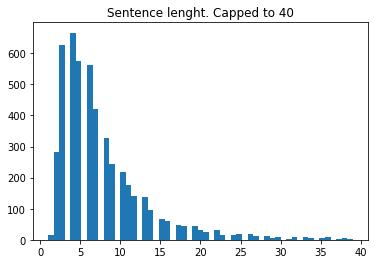

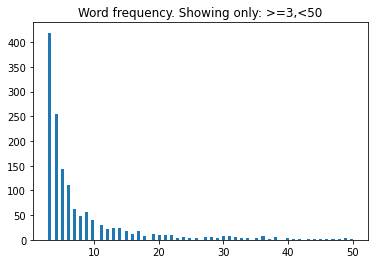

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
keep_words 402 / 6470 = 0.0621


In [ ]:
# %%time
#TODO: multicpu

voc = Voc(corpus_name)

hist = []  
for i, s in loadLines(corpus,LINES_USED):
    s_l = len(s)
    hist.append(s_l)
    voc.addSentence(s)
    
print(f'NUmero de palabras: {voc.num_words}')

arr = np.array(hist)
plt.hist(arr, bins='auto')  # arguments are passed to np.histogram
plt.title(f"Sentence lenght. Capped to {MAX_LENGTH}")
plt.show()



hist=[]
for i,n in enumerate(voc.word2count):
    c = voc.word2count[n]
    if c>=3:
        hist.append(c)
        
arr = np.array(hist)
plt.hist(arr, bins=100,range=(3,50))  # arguments are passed to np.histogram
plt.title(f"Word frequency. Showing only: >=3,<50")
plt.show()



from collections import Counter
c = Counter(voc.word2count)
c.most_common()




#Check de la puntuacion
import string 
print(string.punctuation)

punt_dict = {}
for word in c:
    for punt in string.punctuation:#",.¿?¡!\":()-{}":
        if punt in word:
            if len(word)>1 and c[word]>MIN_COUNT:
                punt_dict[word] = c[word]
c2 = Counter(punt_dict)
c2.most_common()




voc.trim(MIN_COUNT)

In [ ]:
def has_trimmed_or_unk(spl_snt):
    """ Filter out sentences with trimmed words or words not in the voc
    spl_snt is a list of words"""
    for word in spl_snt:
        if word not in voc.word2index:
            return True

trm_unk = 0
for i,s in loadLines(corpus,LINES_USED):
    if has_trimmed_or_unk(s): trm_unk +=1
        
full_pairs =  LINES_USED - trm_unk      

print(f"From {LINES_USED} pairs, {full_pairs} does not contain trimmed or unkonwn words,", 
      f"{full_pairs / LINES_USED:.4f} of total")


#aumentando min_count de 3 a 5 el vocabulario pasa de 72510(57%) a 36642(29%), sin embargo las frases aceptadas 
#solo baja un 6%, de 97.33% a 91.27%, o lo que es más impactante, con un tercio del vocabulario total podemos 
#recrear más del 90% del dataset , TODO restestear con diferentes min count cuando este el multicpu


# spl_snt is a list of words
def indexesFromSentence(spl_snt, voc):
    idxs = []
    for word in spl_snt:
        try:
            idxs += [voc.word2index[word]]
        except:
            idxs += [UNK_token] #word2index["UNK"]=UNK_token
    return idxs + [EOS_token]

def gen_pairs(how_many, voc):
    first_inp = True
    n=0
    for out_idx, out_snt in loadLines(corpus,LINES_USED):
        
        if first_inp: #first cycle, set first input
            inp_idx, inp_snt = out_idx, out_snt
            first_inp = False
            continue

        if inp_idx+1 == out_idx: #frases contiguas (loadLines filter long sentences)
            ok_inp = True if WITH_UNK else not has_trimmed_or_unk(inp_snt) # if WITH_UNK==True, every inp is accepted
            ok_out = not has_trimmed_or_unk(out_snt)
            
            if ok_inp and ok_out: #every word is in Voc
                n+=1
                yield [indexesFromSentence(inp_snt, voc),indexesFromSentence(out_snt, voc)]
        
        if n==how_many:break
        inp_idx, inp_snt = out_idx, out_snt #prepare next cycle
        
for pair in gen_pairs(10,voc): print(pair)


#check finales paris
for pair in gen_pairs(10,voc): 
    for i in pair:
        snt = []
        for idx in i:
            snt += [voc.index2word[idx]]
        print(*snt)
    print("---")


pairs = list(gen_pairs(LINES_USED,voc))

"""
se obtienen menos pares que lineas usadas, con lineas usadas se crea el diccionario, con ese diccionario elegimos 
las palabras con las que quedarnos, se descartan las lineas con palabras borradas y de ahi solo cogemos los pares
de lineas contiguos
"""
len(pairs)

From 5000 pairs, 939 does not contain trimmed or unkonwn words, 0.1878 of total
[[24, 25, 3, 26, 3, 27, 3, 3, 28, 2], [19, 7, 2]]
[[67, 53, 3, 3, 68, 62, 3, 3, 43, 60, 69, 3, 7, 2], [24, 70, 71, 72, 28, 2]]
[[27, 3, 10, 74, 75, 8, 76, 3, 73, 26, 77, 78, 7, 2], [79, 80, 81, 82, 78, 7, 7, 7, 2]]
[[3, 12, 3, 26, 3, 10, 3, 3, 7, 2], [95, 7, 2]]
[[19, 102, 3, 103, 10, 30, 12, 3, 7, 2], [104, 56, 38, 7, 2]]
[[120, 19, 35, 3, 56, 131, 3, 7, 7, 7, 133, 19, 12, 132, 76, 3, 5, 3, 7, 2], [59, 134, 43, 120, 131, 7, 2]]
[[59, 134, 43, 120, 131, 7, 2], [39, 135, 136, 7, 2]]
[[74, 131, 100, 3, 10, 3, 137, 3, 10, 138, 3, 19, 27, 8, 10, 3, 139, 7, 2], [140, 141, 7, 2]]
[[24, 106, 3, 3, 97, 28, 2], [35, 58, 7, 2]]
[[59, 3, 3, 119, 8, 3, 7, 2], [24, 146, 147, 33, 148, 28, 2]]
¿ le UNK el UNK a UNK UNK ? EOS
no . EOS
---
tan solo UNK UNK mío y UNK UNK por ella cuando UNK . EOS
¿ les parece bien ? EOS
---
a UNK de ese momento los tres UNK todo el tiempo juntos . EOS
durante todos nuestros años juntos . . .

934

In [ ]:
#Guardar pairs y voc
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
with open(save_dir + '/pairs.pkl', 'wb') as file:
    pickle.dump(pairs, file)

with open(save_dir + '/voc.pkl', 'wb') as file:
    voc.__module__ = "Voc"
    pickle.dump(voc, file)


# # Example for validation of the code
# small_batch_size = 6
# pairs_list = [random.choice(pairs) for _ in range(small_batch_size)]
# batches = batch2TrainData(pairs_list)
# input_variable, lengths, target_variable, mask, max_target_len = batches

# print("input_variable:\n", input_variable)
# print("lengths:", lengths)
# print("target_variable:\n", target_variable)
# print("mask:\n", mask)
# print("max_target_len:", max_target_len)

In [ ]:
#---------------- sentencepiece ---------------------------
! pip install sentencepiece

In [ ]:
import sentencepiece as spm
from settings import *
import pickle

In [ ]:
def load_lines(how_many):
    n = 0
    with open(corpus, 'rb') as readfl:
        for i, line in enumerate(readfl):
            if max(line.find(b"["),line.find(b"]")) == -1: #filtra los comentarios
                n+=1
                line = line.lstrip(b"- ").decode()
                yield i,line
                if n==total_lines: break

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
total_lines=500_000

with open(f"{save_dir}/writefile.txt", 'w') as writefl:
    for i,line in load_lines(total_lines):
        writefl.write(line)


cmd = (f'--input={save_dir}/writefile.txt --vocab_size=15000 --model_prefix=m_bpe --model_type=bpe '
       f'--pad_id={PAD_token} --unk_id={UNK_token} --bos_id={SOS_token} --eos_id={EOS_token} --pad_piece=[PAD] '
       f'--unk_piece=[UNK] --bos_piece=[SOS] --eos_piece=[EOS] --normalization_rule_name=nfkc_cf')

spm.SentencePieceTrainer.train(cmd)
os.rename('./m_bpe.vocab',f'{save_dir}/m_bpe.vocab')
os.rename('./m_bpe.model',f'{save_dir}/m_bpe.model')

sp = spm.SentencePieceProcessor()
sp.load(f'{save_dir}/m_bpe.model')

True

In [ ]:
for id in range(4):
    print(sp.id_to_piece(id), sp.is_control(id))

print('bos=', sp.bos_id(),', eos=', sp.eos_id(),', unk=', sp.unk_id(),', pad=', sp.pad_id())

# print(sp.encode_as_ids('Hello world'))
# print([sp.bos_id()] + sp.encode_as_ids('H O L A world') + [sp.eos_id()])

# print(sp.encode_as_pieces('Hello world'))
# print(sp.encode_as_pieces('HOLA Hola hola mundo estás')) 
# print([sp.bos_id()] + sp.encode_as_ids('Hola mundo estás') + [sp.eos_id()])


def gen_pairs(how_many): #how many loaded line, pairs will be less
    prev_ln = None
    for i, line in load_lines(how_many):
        if prev_ln == None: 
            prev_ln = sp.encode_as_ids(line.strip()) + [EOS_token]
            prev_idx= i
            continue
        
        line = sp.encode_as_ids(line.strip()) + [EOS_token]
        if prev_idx+1 == i:
            yield [prev_ln,line]

        if i == how_many: break
        prev_ln = line
        prev_idx= i


# for pair in gen_pairs(100):
#     print(pair[0],sp.encode_as_pieces(sp.decode_ids(pair[0])),sp.decode_ids(pair[0]),sep="\n")
#     print(pair[1],sp.encode_as_pieces(sp.decode_ids(pair[1])),sp.decode_ids(pair[1]),sep="\n")
#     print()


pairs = list(gen_pairs(LINES_USED))


with open(save_dir + '/sp_pairs.pkl', 'wb') as file:
    pickle.dump(pairs, file)

[PAD] True
[SOS] True
[EOS] True
[UNK] False
bos= 1 , eos= 2 , unk= 3 , pad= 0


## Definimos el Modelo (Seq2Seq)

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import pickle, random, itertools, os
import numpy as np
import matplotlib.pyplot as plt

from pre_processing import Voc
from settings import *

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("device = ", device)

device =  cuda


### Loading data and batching

In [ ]:
with open(save_dir + '/voc.pkl',  'rb') as f:
    voc   = pickle.load(f)
    
with open(save_dir + '/pairs.pkl','rb') as f:
    pairs = pickle.load(f)
    
##with open("./data/loss_log.pkl", 'rb') as f:
##    loss_log = pickle.load(f)

In [ ]:
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(indexes_batch):
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(indexes_batch):
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(pair_batch):
    pair_batch.sort(key=lambda x: len(x[0]), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch)
    output, mask, max_target_len = outputVar(output_batch)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 6
pairs_list = [random.choice(pairs) for _ in range(small_batch_size)]
batches = batch2TrainData(pairs_list)
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:\n", input_variable)
print("lengths:", lengths)
print("target_variable:\n", target_variable)
print("mask:\n", mask)
print("max_target_len:", max_target_len)

input_variable:
 tensor([[ 21, 307,  24,  24, 106,   3],
        [ 74,   3,  41, 104,  19,   3],
        [ 75,  10,   3,   3,   3,   7],
        [133,  30,   5,  48,  34,   2],
        [100,  12,   6,  41,   7,   0],
        [  3, 132,   3,  28,   2,   0],
        [255, 128,  28,   2,   0,   0],
        [101,  62,   2,   0,   0,   0],
        [ 12, 128,   0,   0,   0,   0],
        [  3,   7,   0,   0,   0,   0],
        [ 66,   2,   0,   0,   0,   0],
        [  7,   0,   0,   0,   0,   0],
        [  2,   0,   0,   0,   0,   0]])
lengths: tensor([13, 11,  8,  7,  6,  4])
target_variable:
 tensor([[ 19, 168, 180,  72, 200,  30],
        [ 84, 300, 152,   7,  12, 185],
        [ 12,   7,  69,   2,  19,   7],
        [ 35,   2, 116,   0,   7,   2],
        [128,   0,  78,   0,   2,   0],
        [106,   0,   7,   0,   0,   0],
        [ 19,   0,   2,   0,   0,   0],
        [ 30,   0,   0,   0,   0,   0],
        [185,   0,   0,   0,   0,   0],
        [  7,   0,   0,   0,   0,   0],
  

### Modelo

Usando el mejor mecanismo de Atención se construye un ChatBot para español usando los datos de open subtitles como sugiere el autor de este Blog: https://mc.ai/como-hacer-un-chatbot-en-espanol-y-que-te-trolee-en-el-intento/


In [ ]:
# Modelo de atención: Soft-Attention
class Soft_Attention(torch.nn.Module):
    #def __init__(self, encoder_dim, decoder_dim):
    def __init__(self, method, hidden_size):
        super(Soft_Attention, self).__init__()
        #super().__init__()

        self.hidden_size = hidden_size 
        self.w_a = torch.nn.Linear(self.hidden_size, hidden_size)
        self.u_a = torch.nn.Linear(self.hidden_size, hidden_size)
        self.v_a = torch.nn.Linear(self.hidden_size, 1, bias = False)
        self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))
        
    #def forward(self, encoder_state_vectors, query_vector):
    def forward(self, query_vector, encoder_state_vectors):

        query_vector2 = query_vector.permute(1,0, 2)
        encoder_state_vectors2 = encoder_state_vectors.permute(1,0, 2)

        batch_size, num_vectors, vector_size = encoder_state_vectors2.size()

        vector_energy = torch.tanh(self.w_a(query_vector2.view(batch_size, 1, vector_size)) + self.u_a(encoder_state_vectors2) ) 
        vector_scores = self.v_a(vector_energy)
        vector_probabilities = F.softmax(vector_scores, dim=1)

        ##weighted_vectors = encoder_state_vectors2 * vector_probabilities.view(batch_size, num_vectors, 1)
        #context_vectors = torch.sum(weighted_vectors, dim=1)
        ##context_vectors = torch.sum(weighted_vectors, dim=2).unsqueeze(1)
        
        #return context_vectors, vector_probabilities, vector_scores
        #return context_vectors #.permute(2,1, 0) #(1,2, 0)
        return vector_probabilities.permute(0,2, 1)


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        #packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths).to(device)

        # Forward pass through GRU
        self.gru.flatten_parameters()
        outputs, hidden = self.gru(embedded, hidden)
        #outputs, hidden = self.gru(packed, hidden)

        # Unpack padding
        #outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]

        # Return output and final hidden state
        return outputs, hidden

# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method

        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1,tie_weights=False):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        #self.attn = Attn(attn_model, hidden_size)
        self.attn = Soft_Attention(attn_model, hidden_size)
        
        if tie_weights:
            self.out.weight = self.embedding.weight

    def forward(self, input_step, last_hidden, encoder_outputs):

        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden


def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Training

In [ ]:
def plot_loss(d):
    x,y=[],[]
    for k,v in d.items():
            x.append(k)
            y.append(v)
    plt.plot(x,y)

def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals


def trainIters(voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, 
               encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, 
               clip, corpus_name, loadFilename, total_iter):

    # Load batches for each iteration
    #TODO: generator form to save memory of training_batches
    training_batches = [batch2TrainData([random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
#     print('Initializing ...')
    start_iteration = 0
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration']

    # Training loop
#     print("Training...")
    for iteration in range(1,n_iteration+1):
        training_batch = training_batches[iteration-1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)

        print_loss += loss
        
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            assert np.isnan(print_loss_avg) == False
            loss_dict[total_iter+iteration] = print_loss_avg
            print(f"Iteration: {iteration}; Percent complete: {iteration / n_iteration * 100:.1f}%; "
                  f"Average loss: {print_loss_avg:.4f}")
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, "checkpoints")
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': start_iteration+iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict(),
                "total_iter": total_iter+iteration,
                'loss': loss_dict #for plotting
            }, os.path.join(directory, f'{start_iteration+iteration}_checkpoint.tar'))

In [ ]:
# Configure models
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500 #tamaño del embedding y del hidden, tienen que ser iguales para el output embedding
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 128

# Set checkpoint to load from; set to None if starting from scratch
train_from_zero = True
load_last_iter  = False
chkpt_dir = os.path.join(save_dir, "checkpoints")

if train_from_zero:
    loadFilename = None
    total_iter = 0
    loss_dict = {}
else:
    if load_last_iter: #load last save
        chkpt = os.listdir(chkpt_dir)[-1]
        loadFilename = os.path.join(chkpt_dir,chkpt)
    else:    
        checkpoint_iter = 20_000 #load especific iter
        loadFilename = os.path.join(chkpt_dir, f'{checkpoint_iter}_checkpoint.tar')

print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)

# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout,True)
print("Nº of params: ", count_parameters(encoder) + count_parameters(decoder))

# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))+
    encoder.load_state_dict(checkpoint['en'])
    decoder.load_state_dict(checkpoint['de'])
    embedding.load_state_dict(checkpoint['embedding'])
    voc.__dict__ = checkpoint['voc_dict']
    total_iter = checkpoint["total_iter"]
    loss_dict = checkpoint["loss"]
    
print('Models built and ready to go!')

Building encoder and decoder ...
Nº of params:  11926906
Models built and ready to go!


In [ ]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1
learning_rate = 4e-5
decoder_learning_ratio = 5.0
n_iteration = 2_000 #10_000
print_every = 1_000
#save_every = 11_000
save_every = 1_000
wd = 1e-5

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate,weight_decay=wd)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio,weight_decay=wd)
if loadFilename:
    encoder_optimizer.load_state_dict(checkpoint['en_opt'])
    decoder_optimizer.load_state_dict(checkpoint['de_opt'])

Building optimizers ...


No. iterations: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


Iteration: 1000; Percent complete: 50.0%; Average loss: 0.6747
Iteration: 2000; Percent complete: 100.0%; Average loss: 0.1002
CPU times: user 2min 45s, sys: 46.5 s, total: 3min 32s
Wall time: 3min 36s


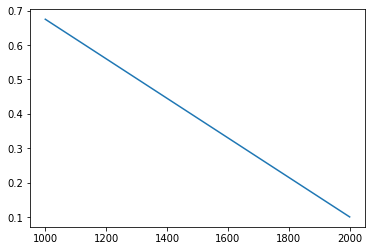

In [ ]:
%%time
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()
loss_log = {}
# Run training iterations
for _ in range(1):
    print(f"No. iterations: {total_iter}")
    trainIters(voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
               embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
               print_every, save_every, clip, corpus_name, loadFilename,total_iter)
    total_iter+=n_iteration
    
    #print("open archivo..")
    with open("./data/loss_log.pkl", 'wb') as f:
        loss_log[corpus_name] = loss_dict
        pickle.dump(loss_log, f)
    plot_loss(loss_dict)

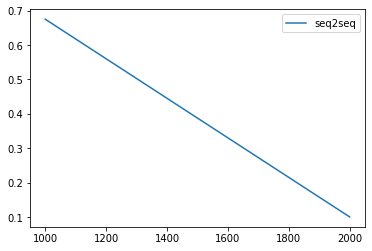

In [ ]:
loss_log['seq2seq'] = loss_log[corpus_name]
loss_log.pop(corpus_name)

#tres metodos de tratar la puntuacion, entrenado por 14 "epochs" con 4e4 y 2 con 4e5
l = list(loss_log.keys())
for k,v in loss_log.items():
    plot_loss(v)
    plt.gca().legend(l)

#next
#test y subir modelo?
#guardar tiempo 10epochs y num params
#grafico de loss escalado a tiempo, y scatter plt de loss at 10 y num of params
#implement outputs layers

#train with simple punct
#reduce data to see how affect to training. smaller data faster training(worse generaliaztion but useful to do test runs)

### Eval

In [ ]:
import re
from pre_processing import process_punct, indexesFromSentence

def custom_capitalize(s):
    for i, c in enumerate(s):
        if c.isalpha():
            break
    return s[:i] + s[i:].capitalize()


def reformatString(l):
    s = l.strip().lower()
#     s = re.sub(r"<guion_inic>",r"", s)
    s = re.sub(r"\s+([.!?])", r"\1", s)
    s = re.sub(r"([¡¿])\s+", r"\1", s)
    s = re.sub(r"\s+", r" ", s)
    return custom_capitalize(s).strip()

class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    sentence = sentence.split()
    indexes_batch = [indexesFromSentence(sentence, voc)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
#             input_sentence = "-"+input_sentence #para que siga el formato de guiones de una conversacion
            input_sentence = process_punct(input_sentence.encode())
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            raw_ans = ' '.join(output_words)
            ans = reformatString(raw_ans)
            print('Bot:',ans)

        except KeyError:
            print("Error: Encountered unknown word.")

In [ ]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> hola
Bot: Hola....................
> que tal
Bot: De acuerdo...................
> como esta todo
Bot: ¿Qué? sargento cutter? guau...............
> yo no soy
Bot: Ahí está...................
> y tu?
Bot: Vamos....................
> a donde?
Bot: Cutter....................
> ya es viernes
Bot: Sí....................
> la noche esta tranquila
Bot: ¿Para qué??................
> para dormir
Bot: Gracias sahib................
> quien eres?
Bot: Y eso es todo..................
> me caes mal
Bot: ¡Sargento ballantine! mío.............
> no te entiendo
Bot: No...............
> sabes decir algo?
Bot: Eso es...................
> nos vemos
Bot: ¿Nos??................
> tu no
Bot: ¡En serio!.................
> solo yo
Bot: Ya esta...................


In [ ]:
### Discusión

### Discusión
Por cuestión de tiempo se tuvo que recortar el tamañó de los datos de entrenamiento y el número de iteracciones al entrenar. Sin embargo, el chatbot parece funcionar relativamente bien, en muchos casos no responde coherentemente, pero en preguntas sencillas con respuestas de si o no logra responder bien.

Considero que el entrenamiento todavía puede mejorar bastante al considerar el corpus completo y el modelo de atención puede ayudar mucho a dar contexto a lo que se pregunta y se responde, más que el producto punto que se usaba antes como score.

In [ ]:
> hola
Bot: Hola....................
> que tal
Bot: De acuerdo...................
> como esta todo
Bot: ¿Qué? sargento cutter? guau...............
> yo no soy
Bot: Ahí está...................
> y tu?
Bot: Vamos....................
> a donde?
Bot: Cutter....................
> ya es viernes
Bot: Sí....................
> la noche esta tranquila
Bot: ¿Para qué??................
> para dormir
Bot: Gracias sahib................
> quien eres?
Bot: Y eso es todo..................
> me caes mal
Bot: ¡Sargento ballantine! mío.............
> no te entiendo
Bot: No...............
> sabes decir algo?
Bot: Eso es...................
> nos vemos
Bot: ¿Nos??................
> tu no
Bot: ¡En serio!.................
> solo yo
Bot: Ya esta...................